In [17]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch
import sklearn
import sklearn.cluster
from torch_geometric.nn import TransformerConv  # Import the Graph Transformer layer
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
class GCN_NET(torch.nn.Module):
    def __init__(self, nhid, nout, dropout):
        super().__init__()
        #self.conv1 = GCNConv(data.num_node_features, nhid)
        #self.conv2 = GCNConv(nhid,nout)
        #self.conv1 = TransformerConv(data.num_node_features, nhid, heads=4)  # You can adjust the number of heads
        #self.conv2 = TransformerConv(nhid * 4, nout)  # Output feat
        #self.conv1 = SAGEConv(data.num_node_features, nhid)
        #self.conv2 = SAGEConv(nhid, nout)
        self.conv1 = GATConv(data.num_node_features,  nhid)  # 多头注意力机制
        self.conv2 = GATConv( nhid , nout)  # 最后一层注意力机制，使用单个头
        #self.conv1 = TransformerConv(data.num_node_features, nhid, heads=4)  # You can adjust the number of heads
        #self.conv2 = TransformerConv(nhid * 4, nout)  # Output feat
        self.dropout = dropout
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,self.dropout , training=self.training)
        x = self.conv2(x, edge_index)
        return x
def cluster(data, k, temp, num_iter, init = None, cluster_temp=5):
    '''
    pytorch (differentiable) implementation of soft k-means clustering.
    '''
    #normalize x so it lies on the unit sphere
    data = torch.diag(1./torch.norm(data, p=2, dim=1)) @ data
    #use kmeans++ initialization if nothing is provided
    if init is None:
        data_np = data.detach().numpy()
        norm = (data_np**2).sum(axis=1)
        init = sklearn.cluster.k_means_._k_init(data_np, k, norm, sklearn.utils.check_random_state(None))
        init = torch.tensor(init, requires_grad=True)
        if num_iter == 0: return init
    mu = init
    n = data.shape[0]
    d = data.shape[1]
#    data = torch.diag(1./torch.norm(data, dim=1, p=2))@data
    for t in range(num_iter):
        #get distances between all data points and cluster centers
#        dist = torch.cosine_similarity(data[:, None].expand(n, k, d).reshape((-1, d)), mu[None].expand(n, k, d).reshape((-1, d))).reshape((n, k))
        dist = data @ mu.t()
        #cluster responsibilities via softmax
        r = torch.softmax(cluster_temp*dist, 1)
        #total responsibility of each cluster
        cluster_r = r.sum(dim=0)
        #mean of points in each cluster weighted by responsibility
        cluster_mean = (r.t().unsqueeze(1) @ data.expand(k, *data.shape)).squeeze(1)
        #update cluster means
        new_mu = torch.diag(1/cluster_r) @ cluster_mean
        mu = new_mu
    dist = data @ mu.t()
    r = torch.softmax(cluster_temp*dist, 1)
    return mu, r, dist

class GCNClusterNet(torch.nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout, K, cluster_temp):
        super(GCNClusterNet, self).__init__()
        self.GCN_NET = GCN_NET(nhid, nout, dropout)
        self.distmult = torch.nn.Parameter(torch.rand(nout))
        self.sigmoid = torch.nn.Sigmoid()
        self.K = K
        self.cluster_temp = cluster_temp
        self.init = torch.rand(self.K, nout)

    def forward(self,x,adj, num_iter=1):
    	#这里的x，adj没有用，为了方便对比本人把它们作为参数加了进来
        embeds = self.GCN_NET(data)
        mu_init, _, _ = cluster(embeds, self.K, 1, num_iter, cluster_temp=self.cluster_temp, init=self.init)
        mu, r, dist = cluster(embeds, self.K, 1, 1, cluster_temp=self.cluster_temp, init=mu_init.detach().clone())
        return mu, r, embeds, dist

In [2]:
def make_modularity_matrix(adj):
    adj = adj * (torch.ones(adj.shape[0], adj.shape[0]) - torch.eye(adj.shape[0]))
    degrees = adj.sum(axis=0).unsqueeze(1)
    mod = adj - degrees @ degrees.t() / adj.sum()
    return mod


def loss_modularity(r, bin_adj, mod):
    bin_adj_nodiag = bin_adj * (torch.ones(bin_adj.shape[0], bin_adj.shape[0]) - torch.eye(bin_adj.shape[0]))
    return (1. / bin_adj_nodiag.sum()) * (r.t() @ mod @ r).trace()


In [3]:
import networkx as nx
# 将边索引转换为 scipy 稀疏矩阵
import community as community_louvain  # Louvain community detection
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, from_scipy_sparse_matrix
import scipy.sparse as sp
import numpy as np
dataset = Planetoid(root='../tmp/Cora', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
print(data)
def enhance_data(data):
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    G = nx.Graph()#创建networkx的空图
    for i in range(num_nodes):
        G.add_node(i, features=data.x[i].cpu().numpy())
    # 添加边
    for i, j in edge_index.T:
        G.add_edge(i, j)
    partition = community_louvain.best_partition(G)
    # 计算模块度
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity: {modularity}")
    # 计算社区数量
    num_communities = len(set(partition.values()))
    print(f"Number of communities: {num_communities}")
    node_embeddings = np.zeros((len(partition), num_communities))
    for node, community in partition.items():
        node_embeddings[node, community] = 1
    # 转换为 PyTorch 张量
    node_embeddings_tensor = torch.tensor(node_embeddings, dtype=torch.float)
    print(np.shape(node_embeddings_tensor))
    # 拼接原特征和独热编码特征
    original_features = data.x.cpu().numpy()  # 获取原始特征，并转换为 numpy 数组
    combined_features = np.hstack((original_features, node_embeddings))  # 拼接特征
    combined_features_tensor = torch.tensor(combined_features, dtype=torch.float).to(device)  # 转换为 PyTorch 张量
    # 更新 data 对象中的特征
    data.x = combined_features_tensor
    return data
data=enhance_data(data)
print("Updated data:")
print(data)

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Modularity: 0.8149844040790168
Number of communities: 105
torch.Size([2708, 105])
Updated data:
Data(x=[2708, 1538], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
##获得数据集的data
# 将 edge_index 转换为稠密的邻接矩阵
print(data)
adj = to_dense_adj(data.edge_index)[0]
def normalize(mx):
    rowsum = np.array(mx.sum(1))  # 矩阵行求和
    r_inv = np.power(rowsum, -1).flatten()  # 每行和的-1次方
    r_inv[np.isinf(r_inv)] = 0.  # 如果是inf，转换为0
    r_mat_inv = sp.diags(r_inv)  # 转换为对角阵
    mx = r_mat_inv.dot(mx)  # D-1*A,乘上特征，按行归一化
    return mx
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
features = sp.csr_matrix(data.x, dtype=np.float32)  # 取特征

adj = sp.coo_matrix((np.ones(data.edge_index.shape[1]), (data.edge_index[0, :], data.edge_index[1, :])),
                    shape=(data.y.shape[0], data.y.shape[0]), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

features = normalize(features)  # 特征归一化
adj = normalize(adj + sp.eye(adj.shape[0]))  # A+I归一化
features = torch.FloatTensor(np.array(features.todense()))# 将numpy的数据转换成torch格式
adj = sparse_mx_to_torch_sparse_tensor(adj)

adj = adj.coalesce()

bin_adj_all = (adj.to_dense() > 0).float()
print(np.shape(bin_adj_all))

Data(x=[2708, 1538], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
torch.Size([2708, 2708])


In [18]:
model_cluster = GCNClusterNet(nfeat=1537, nhid=50, nout=50, dropout=0.2, K=7, cluster_temp=50)
bin_adj_all = (adj.to_dense() > 0).float()
optimizer = torch.optim.Adam(model_cluster.parameters(), lr=0.01, weight_decay=5e-4)
test_object = make_modularity_matrix(bin_adj_all)
model_cluster.train()
num_cluster_iter = 1
losses = []
Graph_GAT_value=[]
for epoch in range(2001):
    mu, r, embeds, dist = model_cluster(features, adj, num_cluster_iter)
    loss = loss_modularity(r, bin_adj_all, test_object)
    loss = -loss
    optimizer.zero_grad()
    loss.backward()
    if epoch == 500:
        num_cluster_iter = 5
    if epoch % 100 == 0:
        r = torch.softmax(100 * r, dim=1)
    loss_test = loss_modularity(r, bin_adj_all, test_object)
    if epoch == 0:
        best_train_val = 100
    if loss.item() < best_train_val:
        best_train_val = loss.item()
        curr_test_loss = loss_test.item()
        # convert distances into a feasible (fractional x)#将距离转换为可行的（分数x）
        x_best = torch.softmax(dist * 100, 0).sum(dim=1)
        x_best = 2 * (torch.sigmoid(4 * x_best) - 0.5)
        if x_best.sum() > 5:
            x_best = 5 * x_best / x_best.sum()
    losses.append(loss.item())
    optimizer.step()
    if epoch%100==0:
        print(f'epoch{epoch + 1}   ClusterNet value:{curr_test_loss}')
        Graph_GAT_value.append(curr_test_loss)

epoch1   ClusterNet value:0.46430185437202454
epoch101   ClusterNet value:0.692524790763855
epoch201   ClusterNet value:0.6931721568107605
epoch301   ClusterNet value:0.6947038769721985
epoch401   ClusterNet value:0.6981161832809448
epoch501   ClusterNet value:0.7039846181869507
epoch601   ClusterNet value:0.7115738391876221
epoch701   ClusterNet value:0.715061366558075
epoch801   ClusterNet value:0.7162284255027771
epoch901   ClusterNet value:0.7168800234794617
epoch1001   ClusterNet value:0.7168800234794617
epoch1101   ClusterNet value:0.7168800234794617
epoch1201   ClusterNet value:0.7200508713722229
epoch1301   ClusterNet value:0.7282491326332092
epoch1401   ClusterNet value:0.7282491326332092
epoch1501   ClusterNet value:0.7282491326332092
epoch1601   ClusterNet value:0.7282491326332092
epoch1701   ClusterNet value:0.7282491326332092
epoch1801   ClusterNet value:0.7282491326332092
epoch1901   ClusterNet value:0.7408682107925415
epoch2001   ClusterNet value:0.7437651753425598


In [20]:
GCN_value=[0.2745811641216278,
 0.7316926121711731,
 0.7321180105209351,
 0.7331862449645996,
 0.7341327667236328,
 0.7514181137084961,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131,
 0.7533242702484131]
Graph_Trans_value=[0.06481173634529114,
 0.7049851417541504,
 0.708267331123352,
 0.7135293483734131,
 0.7170732021331787,
 0.7203065752983093,
 0.7225600481033325,
 0.7333625555038452,
 0.7350120544433594,
 0.7389606237411499,
 0.73995041847229,
 0.7562191486358643,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612,
 0.7563516497612]
Graph_SAGE_value=[0.09624796360731125,
 0.7247584462165833,
 0.7279928922653198,
 0.7340372204780579,
 0.734595000743866,
 0.735374391078949,
 0.7355443835258484,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7357504367828369,
 0.7496438026428223,
 0.751311182975769,
 0.7526584267616272,
 0.7526584267616272,
 0.7535642981529236,
 0.7535642981529236]
Graph_GAT_value=[0.46430185437202454,
 0.692524790763855,
 0.6931721568107605,
 0.6947038769721985,
 0.6981161832809448,
 0.7039846181869507,
 0.7115738391876221,
 0.715061366558075,
 0.7162284255027771,
 0.7168800234794617,
 0.7168800234794617,
 0.7168800234794617,
 0.7200508713722229,
 0.7282491326332092,
 0.7282491326332092,
 0.7282491326332092,
 0.7282491326332092,
 0.7282491326332092,
 0.7282491326332092,
 0.7408682107925415,
 0.7437651753425598]

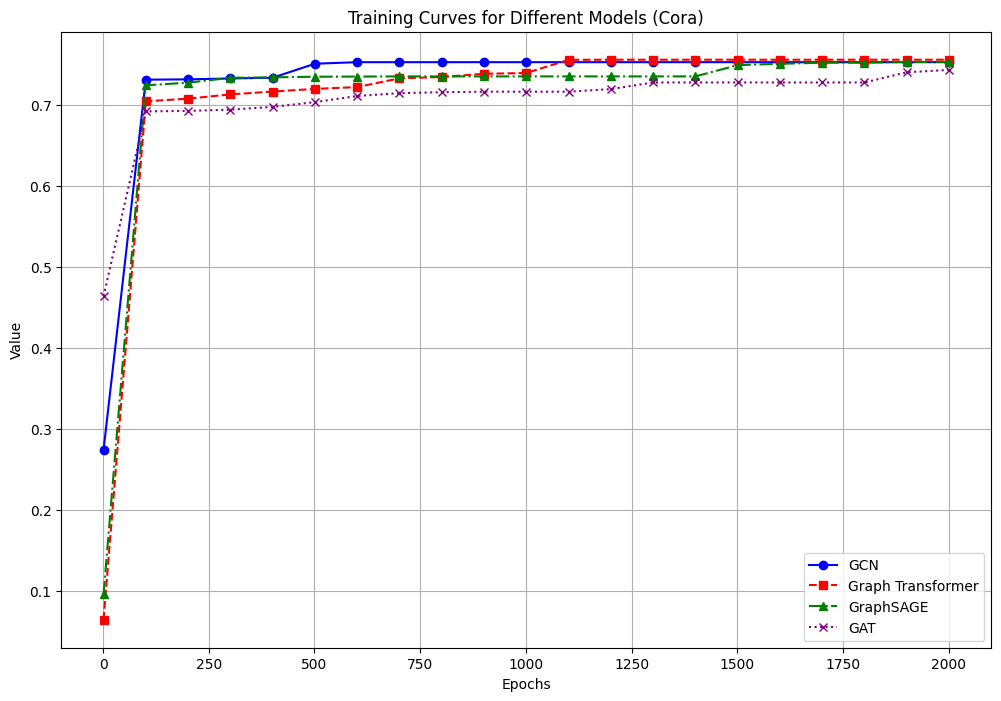

In [26]:
import matplotlib.pyplot as plt
import numpy as np# 每100个 epoch 的训练结果
epochs = np.arange(1, 2101, 100)  # 从100到2000，每100为一个间隔
# 创建图形和轴
plt.figure(figsize=(12, 8))

# 绘制每个模型的训练曲线

# 绘制每个模型的训练曲线
plt.plot(epochs, GCN_value, color='blue', linestyle='-', marker='o', label='GCN')
plt.plot(epochs, Graph_Trans_value, color='red', linestyle='--', marker='s', label='Graph Transformer')
plt.plot(epochs, Graph_SAGE_value, color='green', linestyle='-.', marker='^', label='GraphSAGE')
plt.plot(epochs, Graph_GAT_value, color='purple', linestyle=':', marker='x', label='GAT')

# 添加标签和标题
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Curves for Different Models (Cora)')
plt.legend()  # 显示图例

# 显示图形
plt.grid(True)
plt.show()